Data loader from :
https://www.kaggle.com/code/kalelpark/herbarium2022-eda-with-pytorch/notebook

Training function is the second model,from the GradCAM
Model : ResNet50, change last layer

In [1]:
import pandas as pd
import numpy as np
import json

import logging as log
import os
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import ticker
#I commented this:
#from models import alexnet, mycnn, mycnn2, resnet
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os
import glob

import gc
import cv2 as cv
import seaborn as sns


import pickle
from tqdm import tqdm
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR,ReduceLROnPlateau
from torch.utils import data


from torch.utils.data import Dataset, DataLoader


In [2]:
# Define relevant variables for the ML task
num_classes = 15501
learning_rate = 0.001
num_epochs = 5  # actual 20 epochs
workers = 0
pin_memory = False
batch_size = 64
#I commented these:
#torch.cuda.empty_cache()
#torch.cuda.reset_max_memory_allocated()
#torch.cuda.synchronize()

In [3]:

# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")


## Custom dataset class & Augmentations


In [4]:
train_dir = '/kaggle/input/herbarium-2022-fgvc9/train_images/'
test_dir = '/kaggle/input/herbarium-2022-fgvc9/test_images/'

with open("/kaggle/input/herbarium-2022-fgvc9/train_metadata.json") as json_file:
    train_meta = json.load(json_file)
with open("/kaggle/input/herbarium-2022-fgvc9/test_metadata.json") as json_file:
    test_meta = json.load(json_file)

## convert JSON to Data frame:

In [5]:
image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

test_ids = [image['image_id'] for image in test_meta]
test_dirs = [test_dir + image['file_name'] for image in test_meta]

train_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

test_df = pd.DataFrame({
    "test_id" : test_ids,
    "test_dir" : test_dirs
})


train_df.head()

,image_id,image_dir,category,genus
0,00000__001,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,1
1,00000__002,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,1
2,00000__003,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,1
3,00000__004,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,1
4,00000__005,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,1


## Mapping Genus:

In [6]:
genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
train_df['genus'] = train_df['genus'].map(genus_map)
train_df

,image_id,image_dir,category,genus
0,00000__001,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,Abies
1,00000__002,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,Abies
2,00000__003,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,Abies
3,00000__004,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,Abies
4,00000__005,/kaggle/input/herbarium-2022-fgvc9/train_image...,0,Abies
...,...,...,...,...
839767,15504__032,/kaggle/input/herbarium-2022-fgvc9/train_image...,15504,Zygophyllum
839768,15504__033,/kaggle/input/herbarium-2022-fgvc9/train_image...,15504,Zygophyllum
839769,15504__035,/kaggle/input/herbarium-2022-fgvc9/train_image...,15504,Zygophyllum
839770,15504__036,/kaggle/input/herbarium-2022-fgvc9/train_image...,15504,Zygophyllum


In [7]:
print('Top 15 Genus ')
print(train_df['genus'].value_counts().head(15))
print()

Top 15 Genus 
Carex           24743
Astragalus      15192
Penstemon       12256
Eriogonum       10063
Erigeron         7135
Euphorbia        7070
Cyperus          6412
Phacelia         6165
Castilleja       5485
Juncus           5440
Quercus          5230
Salix            4946
Crataegus        4890
Rhynchospora     4635
Asclepias        4540
Name: genus, dtype: int64



## Data Visualization:

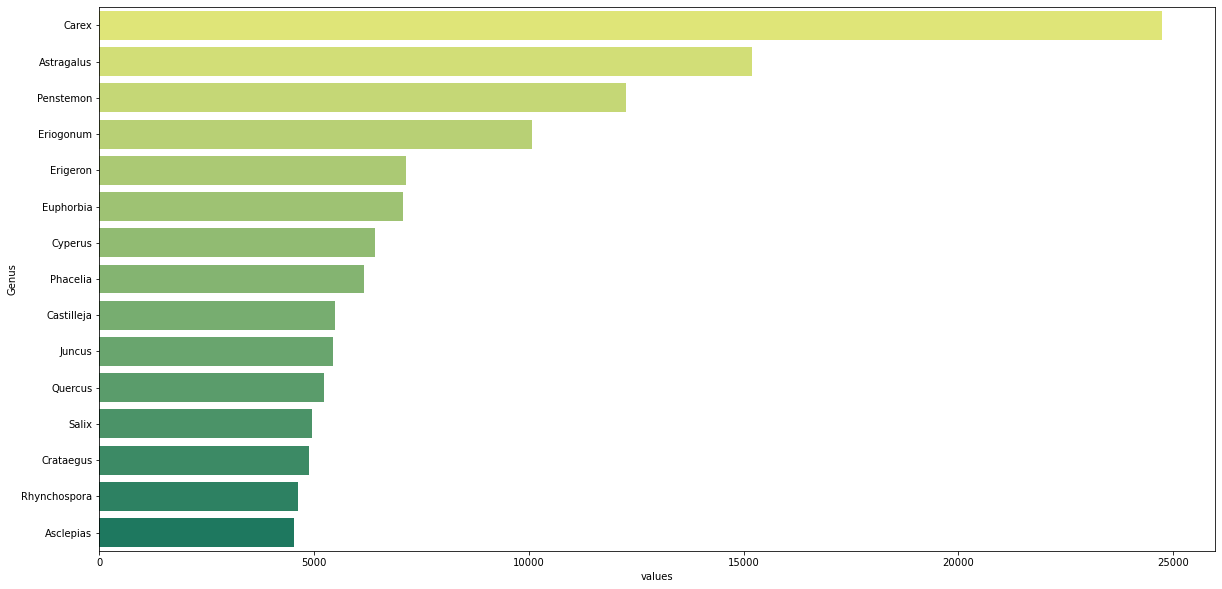

In [9]:
data = train_df['genus'].value_counts().head(15)
data = pd.DataFrame({'Genus' : data.index,
                     'values' : data.values})
plt.figure(figsize = (20, 10))
sns.barplot(x='values', y = 'Genus', data = data , palette='summer_r')
plt.show()

In [11]:
def show_images(speices):
    images = train_df.loc[train_df['genus'] == speices]['image_dir'][:6]
    i = 1
    fig = plt.figure(figsize = (18, 18))
    plt.suptitle(speices, fontsize = '30')
    for image in images:
        img = cv.imread(image)
        ax = fig.add_subplot(2, 3, i)
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()

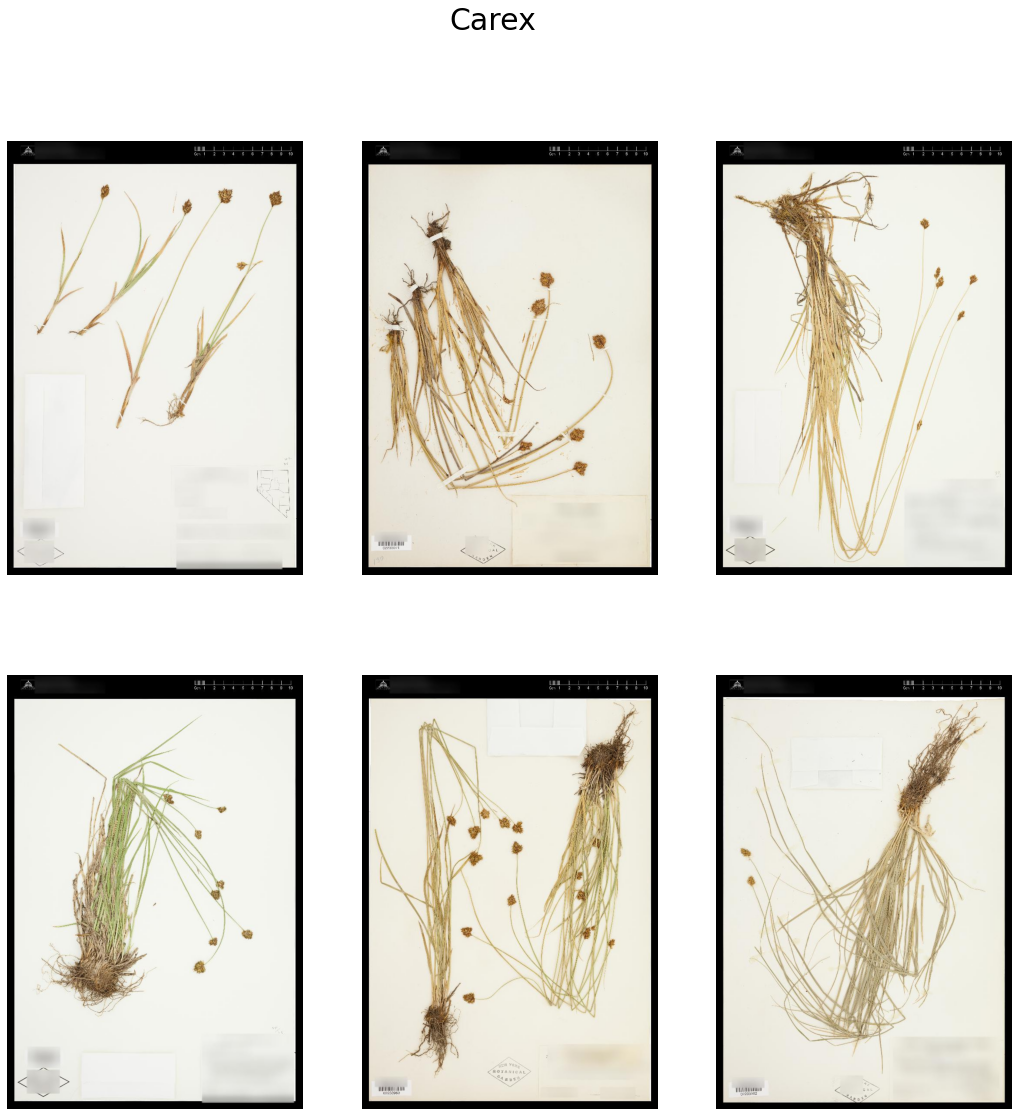

In [12]:
show_images('Carex')

# Training:

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [14]:
BATCH = 128
EPOCHS = 5

LR = 0.01
IM_SIZE = 224 

X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values

Transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [15]:
len(train_df['category'])

839772

In [16]:
class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        x = Image.open(self.fnames[index])
    
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset = GetData(X_Train, Y_Train, Transform)
trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True)

N_Classes = train_df['category'].nunique()
next(iter(trainloader))[0].shape

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#model = torchvision.models.ResNet50(pretrained=True)

model = torchvision.models.resnet50()
model.to(device)

#models.densenet169(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

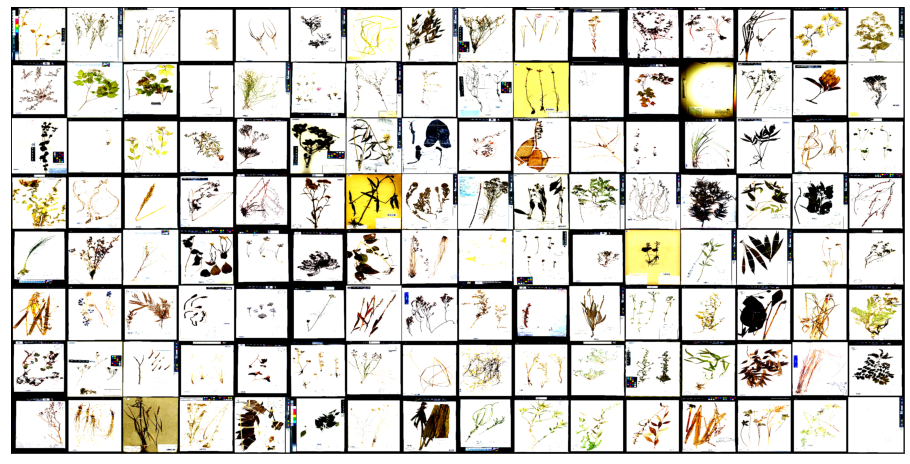

In [17]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(trainloader)

In [18]:
train_df['category'].nunique()

15501

In [19]:
for name, param in model.named_parameters():
    if 'fc' not in name:
        print(name, param.requires_grad)
        param.requires_grad=False

model.fc = nn.Linear(512, num_classes)

if torch.cuda.is_available():
    model.cuda()

#print(model.classifier.in_features) 
#print(model.classifier.out_features)
#(fc): Linear(in_features=512, out_features=1000, bias=True)

#for param in model.parameters():
    #param.requires_grad = False
    
#n_inputs = model.classifier.in_features
#last_layer = nn.Linear(n_inputs, N_Classes)
#model.classifier = last_layer
#if torch.cuda.is_available():
   # model.cuda()
#print(model.classifier.out_features)    

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.classifier.parameters())

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [23]:
# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossFn = nn.CrossEntropyLoss()


In [24]:

# -------------------------------------------------------------------------------------------------------
# Train the model
# -------------------------------------------------------------------------------------------------------

for images, labels in trainloader:
    log.info(f"Shape of X [N, C, H, W]: {images.shape}")
    log.info(f"Shape of y: {labels.shape} {labels.dtype}")
    # test one flow
    # pred = model(x)
    # loss = lossFn(pred, y)
    break
total_step = len(trainloader)
log.info(f"Total steps: {total_step}")

stepsize = total_step // 100
if stepsize < 10:
    stepsize = 10


In [25]:
# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(trainloader):

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                # perform a forward pass and calculate the training loss
                outputs = model(images)
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(trainloader)
    avgAccuracy = totalTrainAccuracy / len(trainloader)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f}, averageloss: {:.4f}, averageacc: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy, avgTrainLoss, avgAccuracy))

    # End Epoch loop

NameError: name 'loss' is not defined